<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Feature extraction. </h2>	


In [31]:
#Import anything you need here
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import skimage
from skimage import data
from skimage import io
import os
import pickle
import seaborn as sns
import cv2 #3.4.2
import PIL
import scipy

# import skimage.filter
from skimage import filters
from skimage import feature
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian

from skimage.feature import daisy
from skimage import data


import random
from random import shuffle
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Speed up pandas 
#https://www.kdnuggets.com/2019/11/speed-up-pandas-4x.html

# import ray
# ray.init(num_cpus=4)
# import modin.pandas as pd

In [4]:
# import dask.dataframe as dd
# import multiprocessing

In [3]:
cv2.__version__

'3.4.2'

<h3> Read in data

In [4]:
starting_data = pd.read_pickle('./starting_data.pkl')
starting_data.head()

,image,label
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
3,"[[[174, 190, 187], [173, 189, 186], [172, 188,...",0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0


<h3> Image Preprocessing: Fill in missing RGB values

In [1]:
#Find rows with missing RGB channels, aka Black and White images
def find_missing(df):
    missing = []
    for ind in df.index: 
        if len(df.image[ind].shape)<3:
            missing.append(ind)
    return missing
find_missing(starting_data)[13] #get one value

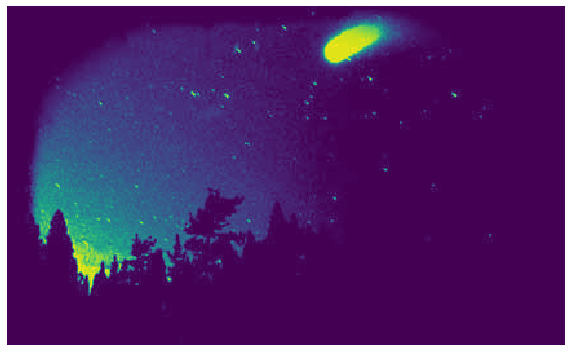

In [6]:
#Visualize images with missing RGB channels
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.imshow(starting_data.image[210])

In [7]:
#View labels for BW images
starting_data.loc[find_missing(starting_data)].label.value_counts

<bound method IndexOpsMixin.value_counts of 169    2
210    3
215    3
217    3
225    3
240    3
242    3
245    3
253    3
256    3
257    3
261    3
262    3
330    4
435    6
740    9
Name: label, dtype: object>

In [8]:
starting_data.loc[find_missing(starting_data)].label.value_counts()

3    12
6     1
4     1
2     1
9     1
Name: label, dtype: int64

In [9]:
12/len(starting_data[starting_data['label']==3])*100

14.814814814814813

<h4> We see only 3 BW images are not in class 3 - this means if we simply drop the images, we lose many images for class 3 (~15%). Instead, we impute missing rgb values using cv2.

In [13]:
def bw_to_rgb(df):
    """
    https://stackoverflow.com/questions/21596281/how-does-one-convert-a-grayscale-image-to-rgb-in-opencv-python-for-visualizing
    """
    missing = find_missing(df)
#     print(missing)
    for i in range(len(missing)):
        image = df.image[missing[i]]
#         print(df.image[missing[i]])
#         print(df.image[missing[i]].shape)
        torgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
#         cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        assert(len(torgb.shape))==3
        df.image[missing[i]]=torgb
#     print(df.image[missing[i]].shape)
    return df

In [11]:
#Fill in missing RGB channels
starting_data = bw_to_rgb(starting_data)

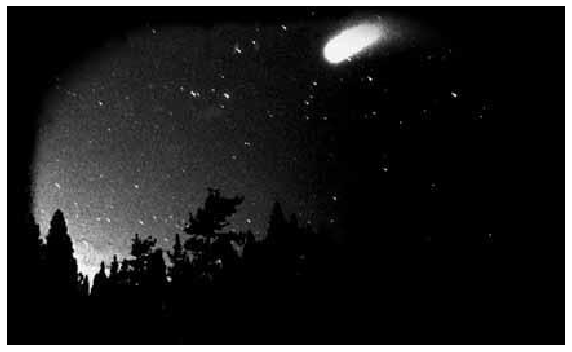

In [12]:
#Visualize images with missing RGB channels; make sure they show up BW
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.imshow(starting_data.image[210])

**Remove before submission**

In [19]:
#Testing pieces
copy = starting_data.copy()
dat  = copy.loc[260:265]
test = copy.image[242]
grayscale = rgb2gray(test)

dat
#20 plane
#3: airplane
#800: kangaroo
#680: ape
#420: dolphin

#620 weird image!!

#242: missing index 3 comet_0038.jpg
#169: missing index 3 blimp_0022.jpg


,image,label
260,"[[[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...",3
261,"[[[173, 173, 173], [175, 175, 175], [178, 178,...",3
262,"[[[47, 47, 47], [44, 44, 44], [37, 37, 37], [3...",3
263,"[[[32, 36, 37], [21, 25, 26], [8, 12, 13], [2,...",3
264,"[[[134, 146, 228], [125, 137, 219], [122, 133,...",3
265,"[[[0, 3, 74], [1, 5, 79], [3, 6, 85], [3, 5, 9...",3


<h3>Image Feature Methods

<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [16]:
def size(image): 
    return image.size

def aspect_ratio(image): 
    """
    Returns the aspect ratio of the image
    """
    return image.shape[1]/image.shape[0]

def r_mean(image):
    """
    Mean pixel value of red channels
    """
    return np.mean(image[:,:,0])

def r_std(image):
    """
    SD pixel value of red channels
    """
    return np.std(image[:,:,0])

def g_mean(image): 
    """
    Mean pixel value of green channels
    """
    return np.mean(image[:,:,1])


def g_std(image): 
    """
    Mean pixel value of green channels
    """
    return np.std(image[:,:,1])

def b_mean(image): 
    """
    Mean pixel value of blue channels
    """
    return np.mean(image[:,:,2])

def b_std(image): 
    """
    SD pixel value of blue channels
    """
    return np.std(image[:,:,2])

def luminance_mean(image):
    """
    return mean value of luminance (Y)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.mean(image[:, :, 0])

def luminance_std(image):
    """
    return SD of luminance (Y)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.std(image[:, :, 0])
    
def cb_mean(image):
    """
    return mean value of blue chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.mean(image[:, :, 1])
def cb_std(image):
    """
    return SD of blue chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.std(image[:, :, 1])

def cr_mean(image):
    """
    return mean value of red chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.mean(image[:, :, 2])
def cr_std(image):
    """
    return SD value of red chroma component (Cb)
    """
    image = skimage.color.rgb2ycbcr(image)
    return np.std(image[:, :, 2])


def fast_corner(image): 
    """
    FAST Algorithm for Corner Detection
    """
    # Image = cv2.imread(image,0)
# Initiate FAST object with default values
    fast = cv2.FastFeatureDetector_create()
    # find and draw the keypoints
    kp = fast.detect(image,None)
    
    # Disable nonmaxSuppression
    fast.setNonmaxSuppression(0)
    kp = fast.detect(image,None)

    return len(kp)

def brief(image):
    """
    BRIEF (Binary Robust Independent Elementary Features)
    """
    # Initiate FAST detector
    star = cv2.xfeatures2d.StarDetector_create()
    # Initiate BRIEF extractor
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    # find the keypoints with STAR
    kp = star.detect(image,None)
    # compute the descriptors with BRIEF
    kp, des = brief.compute(image, kp)
    return len(kp)

def orb(image): #ORB (Oriented FAST and Rotated BRIEF)
    
    orb = cv2.ORB_create()
    # find the keypoints with ORB
    kp = orb.detect(image,None)
    # compute the descriptors with ORB
    kp, des = orb.compute(image, kp)
#     # draw only keypoints location,not size and orientation
#     img2 = cv2.drawKeypoints(test, kp, None, color=(0,255,0), flags=0)
#     plt.imshow(img2), plt.show()
    return len(kp)

def sift(image): #Returns SIFT (Scale Invariant Feature Transform)
    # Image = cv2.imread(image)
    Operated_Image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(Operated_Image,None)
    kp, des = sift.detectAndCompute(Operated_Image,None)
    return len(kp) #pd.Series((len(kp), len(des)))

#     return [len(kp), len(des)] # kp is keypoints and des is descriptors

def surf(image): #Returns SURF (Speeded-Up Robust Features) 


# Create SURF object. You can specify params here or later.
# Here I set Hessian Threshold to 400
    surf = cv2.xfeatures2d.SURF_create(400)
# Find keypoints and descriptors directly
    kp, des = surf.detectAndCompute(image,None)
    return len(kp) # kp is keypoints and des is descriptors , len(des)]

def feature_avg_hog(image):#TOO LONG
    """
    compute mean Histogram of Oriented Gradients (HOG) flattened vector
    """
#     return skimage.feature.hog(image).mean()
    return skimage.feature.hog(image).mean()

def daisy_features(image): #TOO LONG
    """
    compute Daisy Features, Boolean
    """
    grayscale = rgb2gray(image)
#     descs = skimage.feature.daisy(grayscale, step=180, radius=58, rings=2, histograms=6,
#                          orientations=8, visualize=True)
    descs = skimage.feature.daisy(grayscale, step=180, radius=50, rings=2, histograms=6,
                         orientations=8, visualize=True)
    return descs

def canny_edges(image): #time: #123.77750611305237
    """
    compute Canny edges
    """
    grayscale = rgb2gray(image)
    edges=skimage.feature.canny(grayscale, sigma=2)
    return (edges*1)

def prewitt_edges(image): 
    """
    #Extracting Edge features
    SOURCE: 
    https://www.analyticsvidhya.com/blog/2019/08/3-techniques-extract-features-from-image-data-machine-learning-python/
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #calculating horizontal edges using prewitt kernel
    edges_prewitt_horizontal = prewitt_h(gray_image)
    #calculating vertical edges using prewitt kernel
    edges_prewitt_vertical = prewitt_v(gray_image)

    return [edges_prewitt_horizontal,edges_prewitt_vertical]

def binarize(image): 
    """
    Binarizing image Gray scaling is richer than Binarizing as it shows the 
    image as a combination of different intensities of Gray. 
    Whereas binarzing simply builds a matrix full of 0s and 1s.
    """
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = threshold_otsu(gray_image)
    binary = gray_image > thresh
    return (binary*1) # this is a matrix based feature

def blur(image): #time: 70.59628701210022
    """
    Blurring algorithm takes weighted average of neighbouring pixels
    to incorporate surroundings color into every pixel. 
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = skimage.filters.gaussian(gray_image,sigma=20)
    return blurred_image

def harris(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)

    return image[dst>0.01*dst.max()]
def shi_tomasi(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
    corners = np.int0(corners)
    return corners


In [18]:
def feature_frame(data):
    """
    Apply all feature functions
    """
    s = time.time()
    df = pd.DataFrame()
    
    df['size'] = data.apply(lambda x: size(x[0]), axis=1)
    df['aspect_ratio'] = data.apply(lambda x: aspect_ratio(x[0]), axis = 1)
    e = time.time()
    print("SIZE Feature Generation Time = {}".format(e-s))
    df['r_mean'] = data.apply(lambda x: r_mean(x[0]), axis = 1)
    e = time.time()
    print("R MEAN Feature Generation Time = {}".format(e-s))
    df['r_std'] = data.apply(lambda x: r_std(x[0]), axis = 1)
    e = time.time()
    print("R STD Feature Generation Time = {}".format(e-s))
    df['g_mean'] = data.apply(lambda x: g_mean(x[0]), axis = 1)
    e = time.time()
    print("G MEAN Feature Generation Time Time = {}".format(e-s))
    df['g_std'] = data.apply(lambda x: g_std(x[0]), axis = 1)
    e = time.time()
    print("G STD Feature Generation Time Time = {}".format(e-s))
    df['b_mean'] = data.apply(lambda x: b_mean(x[0]), axis = 1)
    e = time.time()
    print("B MEAN Feature Generation Time = {}".format(e-s))
    df['b_std'] = data.apply(lambda x: b_std(x[0]), axis = 1)
    e = time.time()
    print("B STD Feature Generation Time = {}".format(e-s))
    df['luminance_mean'] = data.apply(lambda x: luminance_mean(x[0]), axis = 1)
    df['luminance_std'] = data.apply(lambda x: luminance_std(x[0]), axis = 1)
    e = time.time()
    print("LUMINANCE Feature Generation Time = {}".format(e-s))
    df['cb_mean'] = data.apply(lambda x: cb_mean(x[0]), axis = 1)
    df['cb_std'] = data.apply(lambda x: cb_std(x[0]), axis = 1)
    e = time.time()
    print("CB Feature Generation Time = {}".format(e-s))
    df['cr_mean'] = data.apply(lambda x: cr_mean(x[0]), axis = 1)
    df['cr_std'] = data.apply(lambda x: cr_std(x[0]), axis = 1)
    e = time.time()
    print("CR Feature Generation Time = {}".format(e-s))
    df['fast_corner'] = data.apply(lambda x: fast_corner(x[0]), axis = 1)
    e = time.time()
    print("FAST Feature Generation Timee = {}".format(e-s))
    df['brief'] = data.apply(lambda x: brief(x[0]), axis = 1)
    e = time.time() #11.346766948699951
    print("BRIEF Feature Generation Timee = {}".format(e-s))
    df['orb'] = data.apply(lambda x: orb(x[0]), axis = 1)
    e = time.time() #14.901576042175293
    print("ORB Feature Generation Time = {}".format(e-s))
    
#     df[['sift_kp', 'sift_des']] = data.apply(
#     lambda x: pd.Series(sift(x[0])), axis=1)
#     e = time.time()
#     print("SIFT Feature Generation Time = {}".format(e-s))
  
    
    df['sift_kp'] = data.apply(lambda x: sift(x[0]), axis = 1)
    e = time.time() #14.901576042175293
    print("SIFT KP Feature Generation Time = {}".format(e-s))
#     df['sift_des'] = data.apply(lambda x: sift(x[0])[1], axis = 1)
#     e = time.time() #14.901576042175293
#     print("SIFT DES Feature Generation Time = {}".format(e-s))
    df['surf_kp'] = data.apply(lambda x: surf(x[0]), axis = 1)
    e = time.time() #14.901576042175293
    print("SURF KP Feature Generation Time = {}".format(e-s))
#     df['surf_des'] = data.apply(lambda x: surf(x[0])[1], axis = 1)
#     e = time.time() #14.901576042175293
#     print("SURF DES Feature Generation Time = {}".format(e-s))
    
#     ###########SPLIT################
#     df['feature_avg_hog'] = data.apply(lambda x: feature_avg_hog(x[0]), axis = 1)
#     e = time.time() #TOO LONG
#     print("HOG Feature Generation Time = {}".format(e-s))
#     df['daisy_features'] = data.apply(lambda x: daisy_features(x[0]), axis = 1)
#     e = time.time() #TOO LONG
#     print("DAISY Feature Generation Time = {}".format(e-s))
    df['canny_edges'] = data.apply(lambda x: canny_edges(x[0]), axis = 1)
    e = time.time() #123.77750611305237
    print("CANNY Feature Generation Time = {}".format(e-s))
     ###########SPLIT################
    df['prewitt_h'] = data.apply(lambda x: prewitt_edges(x[0])[0], axis = 1)
    e = time.time() #16.622008085250854 
    print("PREWITT EDGES HOR Feature Generation Time = {}".format(e-s))
    df['prewitt_v'] = data.apply(lambda x: prewitt_edges(x[0])[1], axis = 1)
    e = time.time() #16.622008085250854 
    print("PREWITT EDGES VER Feature Generation Time = {}".format(e-s))
    
    df['binarize'] = data.apply(lambda x: binarize(x[0]), axis = 1)
    e = time.time() #2.9614150524139404
    print("BINARIZE Feature Generation Time = {}".format(e-s))
    df['harris'] = data.apply(lambda x: harris(x[0]), axis = 1)
    e = time.time() #8.947826862335205
    print("HARRIS Feature Generation Time = {}".format(e-s))
    df['shi_tomasi'] = data.apply(lambda x: shi_tomasi(x[0]), axis = 1)
    e = time.time()
    print("SHI TOMASI Feature Generation Time = {}".format(e-s))
    e = time.time() #7.886998176574707
    print("FINAL Time = {}".format(e-s))
    return df

In [70]:
starting_data.shape

(1501, 2)

In [66]:
starting_data.head()

,image,label
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
3,"[[[174, 190, 187], [173, 189, 186], [172, 188,...",0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0


In [16]:
#Create features frame
features = feature_frame(starting_data)
features.head()

SIZE Feature Generation Time = 0.1052861213684082
R MEAN Feature Generation Time = 0.5655810832977295
R STD Feature Generation Time = 2.4278552532196045
G MEAN Feature Generation Time Time = 2.842649221420288
G STD Feature Generation Time Time = 4.653338193893433
B MEAN Feature Generation Time = 5.045180082321167
B STD Feature Generation Time = 6.621925115585327
LUMINANCE Feature Generation Time = 26.570298194885254
CB Feature Generation Time = 48.48794913291931
CR Feature Generation Time = 66.99602317810059
FAST Feature Generation Timee = 71.89154005050659
BRIEF Feature Generation Timee = 80.83483815193176
ORB Feature Generation Time = 91.13852715492249
SIFT KP Feature Generation Time = 253.06327414512634
SURF KP Feature Generation Time = 339.3274528980255
CANNY Feature Generation Time = 446.54128217697144
PREWITT EDGES HOR Feature Generation Time = 459.001177072525
PREWITT EDGES VER Feature Generation Time = 473.6182131767273
BINARIZE Feature Generation Time = 481.147891998291
HARRIS

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,brief,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi
0,195816,2.426829,183.355727,56.406650,176.750337,64.039966,149.151581,79.648356,166.791454,53.495949,...,38,398,340,266,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[205, 203, 164], [205, 203, 162], [226, 223, ...","[[[166, 116]], [[366, 72]], [[89, 128]], [[59,..."
1,221352,2.179348,210.739822,55.293247,189.280101,74.486619,164.805242,70.417988,181.672576,56.847182,...,52,413,207,203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[244, 203, 185], [240, 181, 163], [242, 179, ...","[[[324, 87]], [[61, 72]], [[311, 116]], [[238,..."
2,194535,2.381818,170.123787,64.391428,147.788681,68.085443,111.753798,89.914294,145.131762,56.089846,...,25,392,466,317,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[208, 221, 237], [188, 201, 217], [160, 173, ...","[[[319, 72]], [[286, 74]], [[165, 92]], [[296,..."
3,200430,2.311765,152.159752,64.525514,132.648316,62.769907,77.917303,83.412773,129.573314,53.570175,...,32,396,575,382,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[226, 209, 191], [212, 195, 177], [192, 174, ...","[[[52, 93]], [[69, 81]], [[264, 65]], [[297, 6..."
4,208560,2.244318,147.397886,73.855439,150.504790,71.385855,86.252963,94.391311,138.168607,62.001119,...,36,407,592,431,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[214, 217, 200], [234, 237, 220], [255, 255, ...","[[[97, 71]], [[136, 9]], [[107, 6]], [[153, 90..."


In [71]:
features.shape

(1501, 22)

In [72]:
# #Save file 
# features.to_pickle('features.pkl')

In [18]:
#Recode with category labels
code_dict = {0:'airplanes',
1:'bear',
2:'blimp',
3:'comet',
4:'crab',
5:'dog',
6:'dolphin',
7:'giraffe',
8:'goat',
9:'gorilla',
10:'kangaroo',
11:'killer-whale',
12:'leopards',
13:'llama',
14:'penguin',
15:'porcupine',
16:'teddy-bear',
17:'triceratops',
18:'unicorn',
19:'zebra'}

features['categories']=features['label'].map(code_dict)

In [19]:
#check
features.head()

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi,label,categories
0,195816,2.426829,183.355727,56.406650,176.750337,64.039966,149.151581,79.648356,166.791454,53.495949,...,340,266,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[205, 203, 164], [205, 203, 162], [226, 223, ...","[[[166, 116]], [[366, 72]], [[89, 128]], [[59,...",0,airplanes
1,221352,2.179348,210.739822,55.293247,189.280101,74.486619,164.805242,70.417988,181.672576,56.847182,...,207,203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[244, 203, 185], [240, 181, 163], [242, 179, ...","[[[324, 87]], [[61, 72]], [[311, 116]], [[238,...",0,airplanes
2,194535,2.381818,170.123787,64.391428,147.788681,68.085443,111.753798,89.914294,145.131762,56.089846,...,466,317,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[208, 221, 237], [188, 201, 217], [160, 173, ...","[[[319, 72]], [[286, 74]], [[165, 92]], [[296,...",0,airplanes
3,200430,2.311765,152.159752,64.525514,132.648316,62.769907,77.917303,83.412773,129.573314,53.570175,...,575,382,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[226, 209, 191], [212, 195, 177], [192, 174, ...","[[[52, 93]], [[69, 81]], [[264, 65]], [[297, 6...",0,airplanes
4,208560,2.244318,147.397886,73.855439,150.504790,71.385855,86.252963,94.391311,138.168607,62.001119,...,592,431,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[214, 217, 200], [234, 237, 220], [255, 255, ...","[[[97, 71]], [[136, 9]], [[107, 6]], [[153, 90...",0,airplanes


In [20]:
# #Save file 
# features.to_pickle('features_labeled.pkl')

<h3> Feature Engineering: Dealing with Feature Matrices

In [ ]:
# features = pd.read_pickle('./features_labeled.pkl') 
# data=features.copy()
# data.head(2)

In [ ]:
#Flatten all matrix-based features
for i in range(0,len(features)):
        data['canny_edges'][i]=data['canny_edges'][i].flatten()
for i in range(0,len(features)):
        data['prewitt_h'][i]=data['prewitt_h'][i].flatten()
for i in range(0,len(features)):
        data['prewitt_v'][i]=data['prewitt_v'][i].flatten()
for i in range(0,len(features)):
        data['binarize'][i]=data['binarize'][i].flatten()
for i in range(0,len(features)):
        data['harris'][i]=data['harris'][i].flatten()
for i in range(0,len(features)):
        data['shi_tomasi'][i]=data['shi_tomasi'][i].flatten()  
        
data.head(2)

In [ ]:
#Summarize matrix-based features as sum or mean
new_data = data.copy()
new_data['canny_edges']=new_data['canny_edges'].apply(lambda x: sum(x))
new_data['prewitt_h']=new_data['prewitt_h'].apply(lambda x: sum(x))
new_data['prewitt_v']=new_data['prewitt_v'].apply(lambda x: sum(x))
new_data['binarize']=new_data['binarize'].apply(lambda x: np.mean(x))
new_data['harris']=new_data['harris'].apply(lambda x: np.mean(x))
new_data['shi_tomasi']=new_data['shi_tomasi'].apply(lambda x: np.mean(x))
new_data.head(2)

In [ ]:
# #Save file 
# new_data.to_pickle('features_flattened.pkl')

 We expect all external sources sited, and significant indication of EDA. 

<h3> Feature Frame Generation for Val Data

In [2]:
#Load in val set
val = pd.read_pickle('./val_data.pkl') 
val.head(2)

,image
0,"[[[80, 79, 74], [56, 55, 50], [54, 53, 48], [4..."
1,"[[[213, 173, 85], [213, 173, 85], [213, 173, 8..."


In [8]:
find_missing(val)

[92, 98, 99, 170, 291, 327, 328, 474, 487, 606, 628]

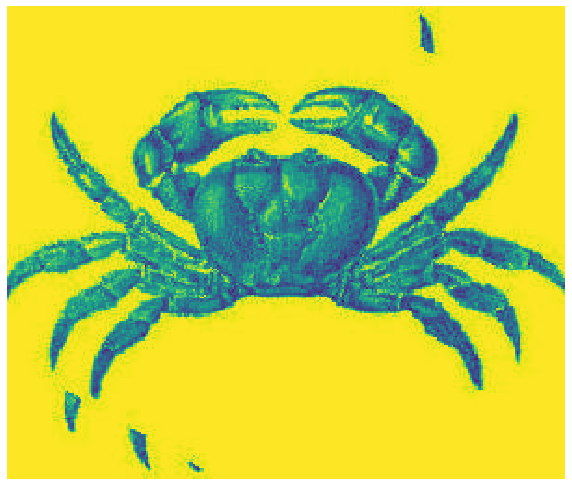

In [11]:
#Visualize images with missing RGB channels
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.imshow(val.image[474])

In [14]:
#Fill in missing RGB channels
val = bw_to_rgb(val)

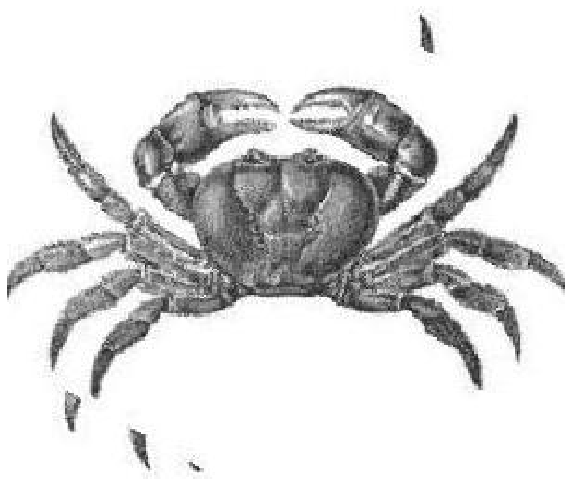

In [15]:
#Visualize images with missing RGB channels; make sure they show up BW
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.imshow(val.image[474])

In [21]:
#Create features frame
val_features = feature_frame(val)

SIZE Feature Generation Time = 0.05235004425048828
R MEAN Feature Generation Time = 0.2486739158630371
R STD Feature Generation Time = 1.0422210693359375
G MEAN Feature Generation Time Time = 1.2830259799957275
G STD Feature Generation Time Time = 1.9711689949035645
B MEAN Feature Generation Time = 2.1269278526306152
B STD Feature Generation Time = 2.7946529388427734
LUMINANCE Feature Generation Time = 12.560304880142212
CB Feature Generation Time = 21.825358867645264
CR Feature Generation Time = 29.97851586341858
FAST Feature Generation Timee = 32.56180787086487
BRIEF Feature Generation Timee = 36.02695870399475
ORB Feature Generation Time = 41.552841901779175
SIFT KP Feature Generation Time = 123.68039774894714
SURF KP Feature Generation Time = 168.39905881881714
CANNY Feature Generation Time = 210.62106585502625
PREWITT EDGES HOR Feature Generation Time = 214.75229287147522
PREWITT EDGES VER Feature Generation Time = 218.84086084365845
BINARIZE Feature Generation Time = 221.00781488

NameError: name 'features' is not defined

In [24]:
val_features.head()
data=val_features.copy()
data.head(2)

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,brief,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi
0,1620000,1.500000,105.980433,67.205121,106.905494,65.316848,105.590887,63.113690,107.446701,56.130446,...,898,500,3970,3274,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[108, 103, 107], [156, 151, 155], [165, 161, ...","[[[541, 357]], [[365, 162]], [[243, 351]], [[2..."
1,1279200,1.500938,112.572315,89.033710,101.316091,78.646389,65.335870,60.860931,102.380433,67.857657,...,86,500,580,498,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[188, 161, 92], [174, 144, 80], [166, 136, 74...","[[[671, 295]], [[596, 281]], [[184, 86]], [[28..."


In [26]:
for i in range(0,len(val_features)):
        data['canny_edges'][i]=data['canny_edges'][i].flatten()
for i in range(0,len(val_features)):
        data['prewitt_h'][i]=data['prewitt_h'][i].flatten()
for i in range(0,len(val_features)):
        data['prewitt_v'][i]=data['prewitt_v'][i].flatten()
for i in range(0,len(val_features)):
        data['binarize'][i]=data['binarize'][i].flatten()
for i in range(0,len(val_features)):
        data['harris'][i]=data['harris'][i].flatten()
for i in range(0,len(val_features)):
        data['shi_tomasi'][i]=data['shi_tomasi'][i].flatten()   

/Users/RiRi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/RiRi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/RiRi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/RiRi/opt/anaconda3/l

In [27]:
data.head(2)

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,brief,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi
0,1620000,1.500000,105.980433,67.205121,106.905494,65.316848,105.590887,63.113690,107.446701,56.130446,...,898,500,3970,3274,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[108, 103, 107, 156, 151, 155, 165, 161, 162, ...","[541, 357, 365, 162, 243, 351, 246, 77, 236, 7..."
1,1279200,1.500938,112.572315,89.033710,101.316091,78.646389,65.335870,60.860931,102.380433,67.857657,...,86,500,580,498,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[188, 161, 92, 174, 144, 80, 166, 136, 74, 155...","[671, 295, 596, 281, 184, 86, 281, 107, 790, 4..."


In [28]:
new_data = data.copy()
new_data['canny_edges']=new_data['canny_edges'].apply(lambda x: sum(x))
new_data['prewitt_h']=new_data['prewitt_h'].apply(lambda x: sum(x))
new_data['prewitt_v']=new_data['prewitt_v'].apply(lambda x: sum(x))
new_data['binarize']=new_data['binarize'].apply(lambda x: np.mean(x))
new_data['harris']=new_data['harris'].apply(lambda x: np.mean(x))
new_data['shi_tomasi']=new_data['shi_tomasi'].apply(lambda x: np.mean(x))

In [29]:
new_data.head(2)

,size,aspect_ratio,r_mean,r_std,g_mean,g_std,b_mean,b_std,luminance_mean,luminance_std,...,brief,orb,sift_kp,surf_kp,canny_edges,prewitt_h,prewitt_v,binarize,harris,shi_tomasi
0,1620000,1.500000,105.980433,67.205121,106.905494,65.316848,105.590887,63.113690,107.446701,56.130446,...,898,500,3970,3274,38530,-182.307190,54.364706,0.387165,136.623414,259.62
1,1279200,1.500938,112.572315,89.033710,101.316091,78.646389,65.335870,60.860931,102.380433,67.857657,...,86,500,580,498,8127,-737.857516,117.811765,0.409045,106.985920,351.28


In [30]:
# #Save file 
new_data.to_pickle('val_features.pkl')

<h4> For EDA, see EDA_NB </h4>

<h4> Sources </h4>

<h4> DataFrame Creation </h4>

## SANDBOX

In [113]:
cv2.__version__

'3.4.2'

In [114]:
skimage.__version__

'0.15.0'

https://apassionatechie.wordpress.com/2017/12/27/create-multiple-pandas-dataframe-columns-from-applying-a-function-with-multiple-returns/